# Init

In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%cd ..
%load_ext autoreload

import plotly.graph_objects as go

c:\Users\kepes\Projects\segmentation


In [6]:
%autoreload 2
from src.MapData import MapData
from src.LineFinder import LineFinder

from src.plotting_functions import plot_embedding, plot_single_variable_map

In [7]:
map_data = MapData()
map_data.get_metadata()
map_data.load_wavelenths()
map_data.load_all_data()
map_data.trim_spectra(64)

In [8]:
map_data.spectra = map_data.spectra[:10000,:].copy()

In [9]:
map_data.get_baseline(min_window_size=50, smooth_window_size=100)
map_data.align_baselines_with_spectra()
map_data.baseline_correct()

In [10]:
map_data.spectra

array([[ 56.71191906,  62.46886931,   6.21068604, ...,  85.15278024,
         64.45464704,  71.73934227],
       [ 71.5987908 ,  94.01354223,  43.71902921, ...,  86.27957303,
         35.9611802 ,  38.97758717],
       [ 54.76681572,  67.75774909,  23.39311951, ..., 105.66860988,
         85.71989501,  82.40457948],
       ...,
       [ 35.42857699,  44.47610592,   3.82401987, ...,  47.37822635,
         11.00962788,  53.62906692],
       [ 28.33433565,  45.05625172,  13.76079162, ...,  55.10060464,
          3.10478419,  44.08855979],
       [ 29.30591732,  42.53952218,  12.42571282, ...,  32.54867068,
         -2.32714765,  38.78206016]])

In [15]:
from random import randint

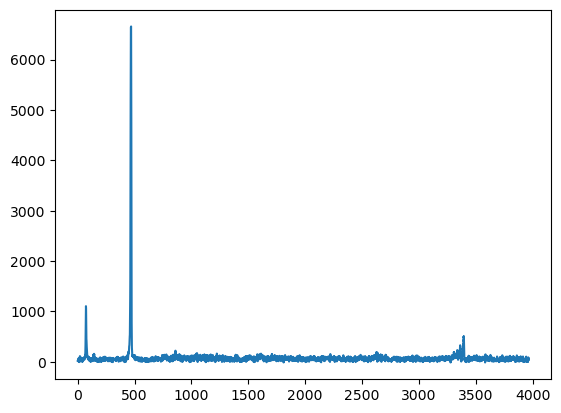

In [35]:
plt.plot(map_data.spectra[randint(0,map_data.spectra.shape[0]),:])

In [38]:
from skimage.restoration import denoise_wavelet

In [50]:
spectrum = map_data.spectra[randint(0,map_data.spectra.shape[0])]

denoised_spectrum = denoise_wavelet(
    spectrum,
    sigma=200,
    wavelet='db2',
    mode='soft', 
    wavelet_levels=7,    
    convert2ycbcr=False,
    method='BayesShrink', 
    rescale_sigma=True
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=map_data.wvl,
        y=spectrum,
        name='baseline corrected'
    )
)
fig.add_trace(
    go.Scatter(
        x=map_data.wvl,
        y=denoised_spectrum,
        name='denoised'
    )
)


[autoreload of src.MapData failed: Traceback (most recent call last):
  File "c:\Users\kepes\Projects\segmentation\pyenv_segment\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\kepes\Projects\segmentation\pyenv_segment\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "c:\Users\kepes\Projects\segmentation\pyenv_segment\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\kepes\Projects\segmentation\src\MapData.py", line 46
    def get_meta